In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [35]:
import re

# Initialize empty arrays
time = []
sinx = []
cosx = []
cos = []
sin = []

# Regex pattern to extract values
pattern = r"time:\s*(\d+),\s*sinx:\s*(-?\d+)\s*,\s*cosx:\s*(-?\d+)\s*,\s*cos:\s*(\d),\s*sin:\s*(\d)"

# Read and parse the file
with open("C:\\Users\\herna\\Downloads\\research\\oscillator\\sin_cos_gen.txt", "r") as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            t, sx, cx, c, s = match.groups()
            time.append(int(t))
            sinx.append(int(sx))
            cosx.append(int(cx))
            cos.append(int(c))
            sin.append(int(s))

# Example usage
print("time:", time[:5])
print("sinx:", sinx[:10000])
print("cosx:", cosx[:1000])



time: [0, 5000, 15000, 25000, 35000]
sinx: [0, 1, 0, 1, 0]
cosx: [16383, 16382, 16383, 16383, 16382]


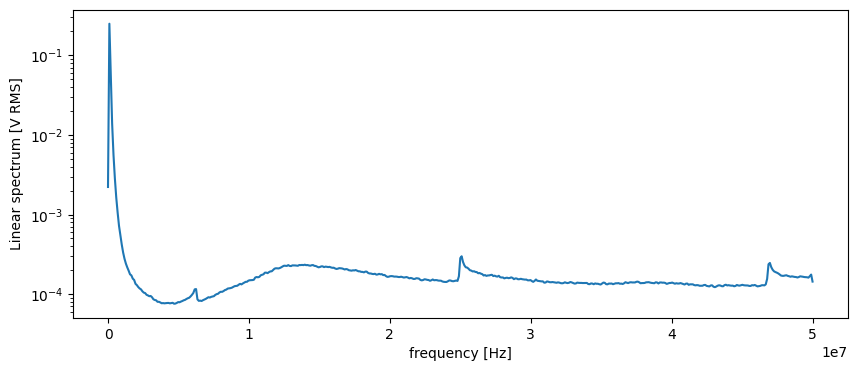

In [ ]:
Fs = (100000000)
x = np.array(sinx)
f, Pxx = scipy.signal.welch(x, fs=Fs, nperseg = 1024)

plt.figure(figsize=(10, 4))

plt.semilogy(f, np.sqrt(Pxx))
plt.xlabel('frequency [Hz]')

plt.ylabel('Linear spectrum [V RMS]')

plt.show()

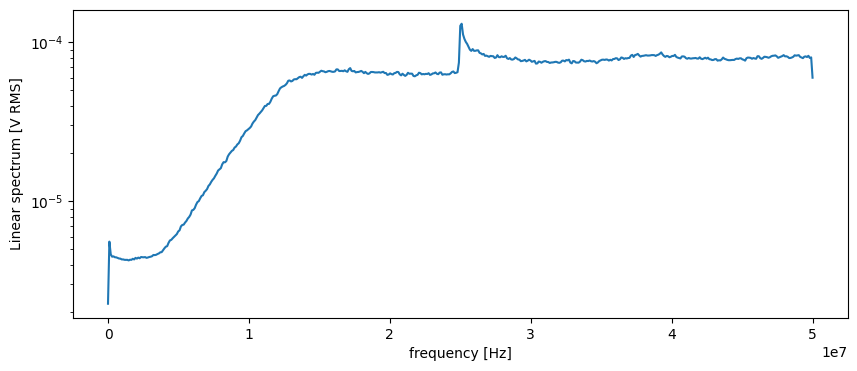

In [ ]:
Fs =100000000
x = np.array(sin)
f, Pxx = scipy.signal.welch(x, fs=Fs, nperseg = 1024)

plt.figure(figsize=(10, 4))

plt.semilogy(f, np.sqrt(Pxx))
plt.xlabel('frequency [Hz]')

plt.ylabel('Linear spectrum [V RMS]')

plt.show()

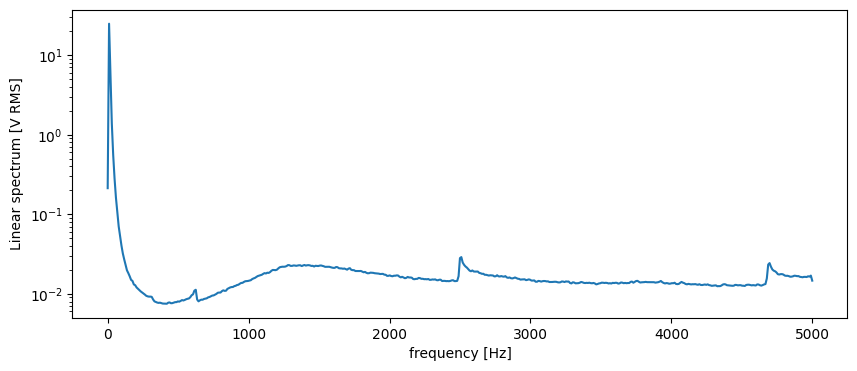

In [ ]:
x = np.array(cosx)
f, Pxx = scipy.signal.welch(x, fs=Fs, nperseg = 1024)

plt.figure(figsize=(10, 4))

plt.semilogy(f, np.sqrt(Pxx))
plt.xlabel('frequency [Hz]')

plt.ylabel('Linear spectrum [V RMS]')

plt.show()

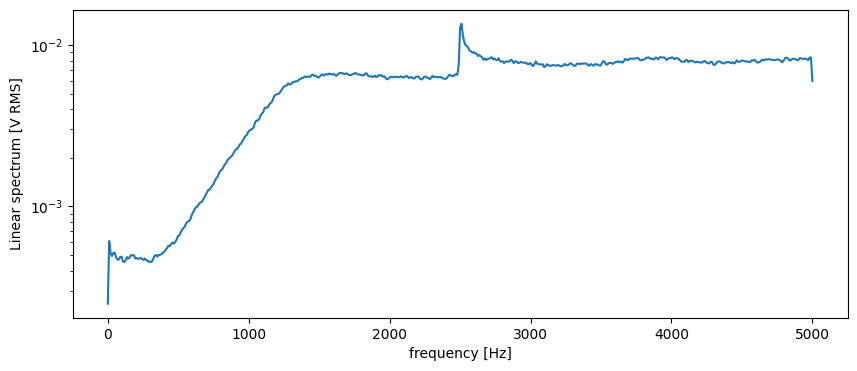

In [ ]:
Fs = 10000
x = np.array(cos)
f, Pxx = scipy.signal.welch(x, fs=Fs, nperseg = 1024)

plt.figure(figsize=(10, 4))

plt.semilogy(f, np.sqrt(Pxx))
plt.xlabel('frequency [Hz]')

plt.ylabel('Linear spectrum [V RMS]')

plt.show()

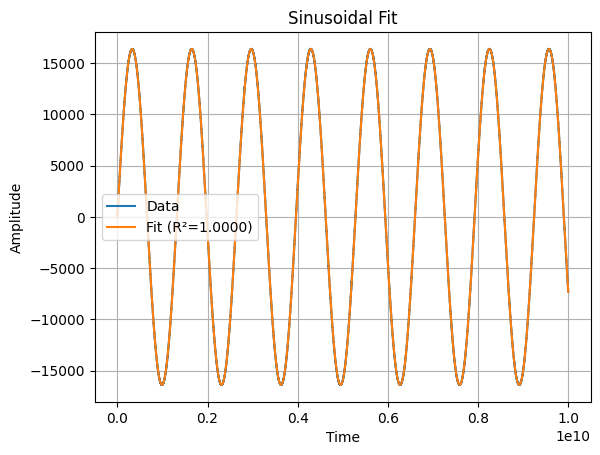

Fit parameters:
  amplitude: 16376.82488097086
  omega: 4.758517300485511e-09
  frequency: 7.573415501605709e-10
  phase: -1.4808187852689998e-05
  offset: 1.01327807833033
  r2: 0.9999966120314379
 Data fits a sinusoid well.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Define the sinusoidal model
def sinusoid(t, A, omega, phi, B):
    return A * np.sin(omega * t + phi) + B

# Fit function
def fit_sinusoid(t, y, plot=False):
    # Estimate omega using FFT
    guess_freq = np.fft.fftfreq(len(t), 10000)[np.argmax(np.abs(np.fft.fft(y)[1:])) + 1]
    guess_omega = 2 * np.pi * guess_freq
    guess_amp = (np.max(y) - np.min(y)) / 2
    guess_offset = np.mean(y)
    guess_phi = 0

    # Initial guess for curve_fit
    guess = [guess_amp, guess_omega, guess_phi, guess_offset]

    try:
        popt, _ = curve_fit(sinusoid, t, y, p0=guess)
        y_fit = sinusoid(t, *popt)
        r2 = r2_score(y, y_fit)

        if plot:
            plt.plot(t, y, label='Data')
            plt.plot(t, y_fit, label=f'Fit (R²={r2:.4f})')
            plt.legend()
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
            plt.title('Sinusoidal Fit')
            plt.grid(True)
            plt.show()

        return {
            'amplitude': popt[0],
            'omega': popt[1],
            'frequency': popt[1] / (2 * np.pi),
            'phase': popt[2],
            'offset': popt[3],
            'r2': r2,
            'fit_success': True
        }

    except Exception as e:
        print(f"Fit failed: {e}")
        return {'fit_success': False}


# Example usage

if __name__ == "__main__":
    # Simulate some test data
    time_np = np.array(time)

    sinx_np = np.array(sinx)
    result = fit_sinusoid(time_np, sinx_np, plot=True)

    if result['fit_success']:
        print("Fit parameters:")
        for k, v in result.items():
            if k != 'fit_success':
                print(f"  {k}: {v}")
        if result['r2'] > 0.9:
            print(" Data fits a sinusoid well.")
        else:
            print("  Data does not fit a sinusoid very well.")
    else:
        print(" Fit could not be completed.")


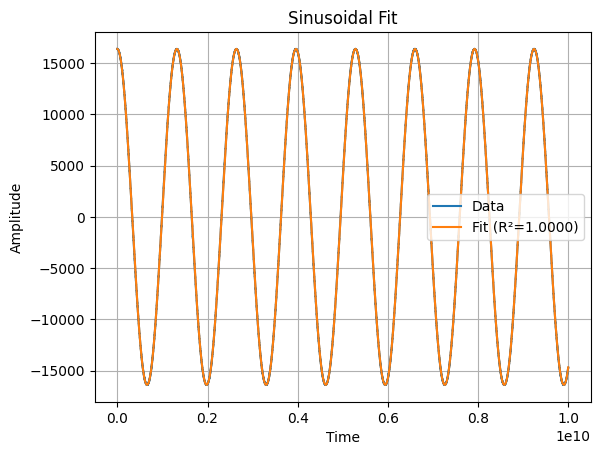

Fit parameters:
  amplitude: -16380.361010340683
  omega: -4.758510334135508e-09
  frequency: -7.573404414315327e-10
  phase: -1.570854624477926
  offset: 1.4934182391951107
  r2: 0.9999969364529052
✅ Data fits a sinusoid well.


In [ ]:
cosx_np = np.array(cosx)
result = fit_sinusoid(time_np, cosx_np, plot=True)

if result['fit_success']:
    print("Fit parameters:")
    for k, v in result.items():
        if k != 'fit_success':
            print(f"  {k}: {v}")
    if result['r2'] > 0.9:
        print(" Data fits a sinusoid well.")
    else:
        print("  Data does not fit a sinusoid very well.")
else:
    print(" Fit could not be completed.")

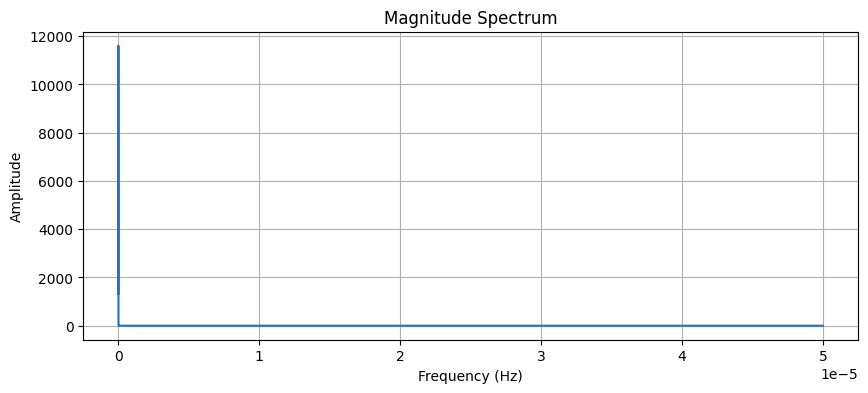

Fundamental frequency: 0.00 Hz
THD: 4.24 %


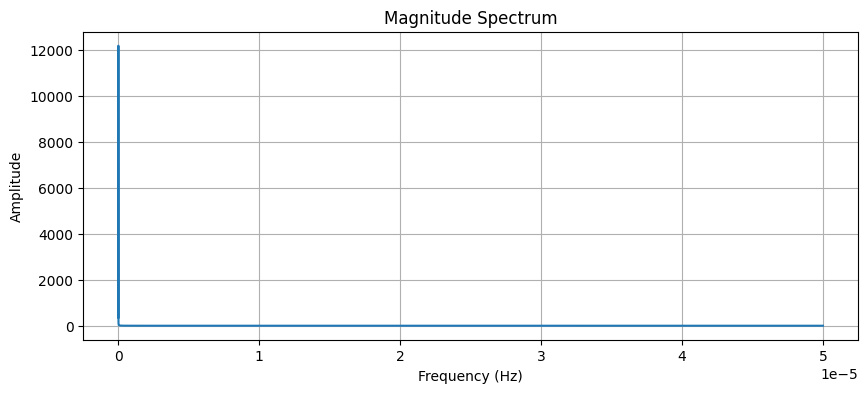

Fundamental frequency: 0.00 Hz
THD: 9.32 %


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def compute_thd(time, signal, num_harmonics=100, plot_spectrum=False):
    # Ensure input is numpy array
    time = np.asarray(time)
    signal = np.asarray(signal)

    # Sampling rate and FFT length
    dt = 10000
    fs = 1 / dt
    N = len(signal)
    # FFT and frequency bins
    fft_vals = fft(signal)
    freqs = fftfreq(N, d=dt)

    # Take only the positive half of spectrum
    pos_mask = freqs > 0
    freqs = freqs[pos_mask]
    magnitudes = 2.0 / N * np.abs(fft_vals[pos_mask])

    # Find fundamental frequency peak
    fundamental_idx = np.argmax(magnitudes)
    fundamental_freq = freqs[fundamental_idx]
    fundamental_mag = magnitudes[fundamental_idx]

    # Collect magnitudes of next `num_harmonics` harmonics
    harmonic_mags = []
    for i in range(2, num_harmonics + 2):  # skip fundamental (i=1)
        harmonic_freq = i * fundamental_freq
        idx = np.argmin(np.abs(freqs - harmonic_freq))
        harmonic_mags.append(magnitudes[idx])

    # Calculate THD
    harmonic_mags = np.array(harmonic_mags)
    thd = np.sqrt(np.sum(harmonic_mags**2)) / fundamental_mag

    # Optionally plot spectrum
    if plot_spectrum:
        plt.figure(figsize=(10, 4))
        plt.plot(freqs, magnitudes)
        plt.title("Magnitude Spectrum")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

    return thd, fundamental_freq

# === Example usage ===
# time = np.linspace(0, 1, 1000)
# signal = np.sin(2 * np.pi * 50 * time) + 0.1 * np.sin(2 * np.pi * 150 * time)
# thd_value, f0 = compute_thd(time, signal, plot_spectrum=True)
# print(f"Fundamental frequency: {f0:.2f} Hz")
# print(f"THD: {thd_value*100:.2f} %")

thd_val, f0 = compute_thd(time_np, sinx_np, plot_spectrum = True)
print(f"Fundamental frequency: {f0:.2f} Hz")
print(f"THD: {thd_val*100:.2f} %")

thd_vall, f1 = compute_thd(time_np, cosx_np, plot_spectrum = True)
print(f"Fundamental frequency: {f1:.2f} Hz")
print(f"THD: {thd_vall*100:.2f} %")


In [50]:
dt = 10000
fs = 1 / dt
N = len(sinx_np)
# FFT and frequency bins
fft_vals = fft(sinx_np)
freqs = fftfreq(N, d=dt)
print(fft_vals)
pos_mask = freqs > 0
freqs = freqs[pos_mask]
magnitudes = 2.0 / N * np.abs(fft_vals[pos_mask])

print(freqs)
print(magnitudes)
fundamental_idx = np.argmax(magnitudes)
fundamental_freq = freqs[fundamental_idx]
fundamental_mag = magnitudes[fundamental_idx]
print(fundamental_freq)

[6.53361172e+08       -0.j         6.65097677e+08+20382841.231959j
 7.01082869e+08+44150245.38614047j ... 7.72849126e+08-72355263.7500948j
 7.01082869e+08-44150245.38614047j 6.65097677e+08-20382841.231959j  ]
[9.999990e-11 1.999998e-10 2.999997e-10 ... 4.999975e-05 4.999985e-05
 4.999995e-05]
[1.33081854e+03 1.40494191e+03 1.55245593e+03 ... 2.81914886e-02
 2.38356868e-02 8.74162644e-03]
7.999992000008e-10
